# Diffusion Models in Depth - Implementation of a diffusion model for ___ using PyTorch

Necessary imports

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from utils import utils

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
# Metal (for M-series Macs)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
# CPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


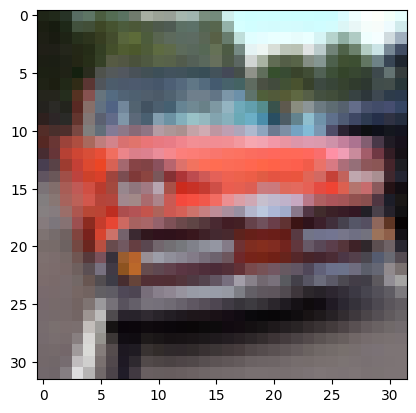

In [30]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


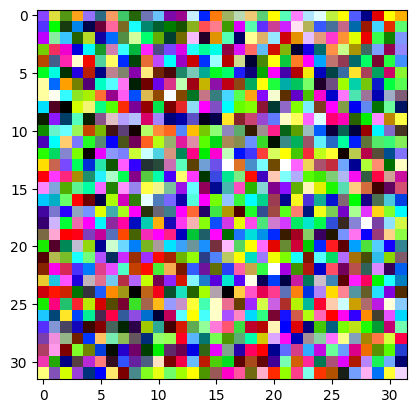

In [31]:
f = utils.cosine_scheduler
s = 0.008
alpha_prod = f(1000, 1000, s) / f(0, 1000, s)
alpha_prod = torch.tensor(alpha_prod, dtype=torch.float32)

x_0 = images[0].to(device)

mu = torch.sqrt(alpha_prod) * x_0
noise = torch.sqrt(1 - alpha_prod) * torch.randn_like(x_0)

x_t = mu + noise

imshow(x_t.to("cpu"))